# Reinforcement Learning
Prof. Milica Gašić

### TD control

In this notebook we will implement the three TD control algorithms SARSA, Q-learning and expected SARSA.  
The main difference between them is the TD target, e.g. for SARSA:

$\begin{equation}
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (\,\underbrace{r_{t+1} + \gamma Q(s_{t+1}, a_{t+1})}_{\text{TD target}} - Q(s_t, a_t))
\end{equation}$

The targets of Q-learning and expected SARSA can be found in the slides.  
Another difference is whether the next action is already selected before the update (only SARSA).

#### Implementation

Make sure that the files `rl_agent.py` and `rl_env.py` are in the same folder as the notebook.

In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import rl_agent
import rl_env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Agents

The class `TDAgent` is a base class and uses the method `compute_target()` to compute the TD target.  
The three TD agents are subclasses of `TDAgent` and only need to implement this method.  
Follow the instructions in the code cells below.

In [12]:
class TDAgent(rl_agent.TabularAgent):

    def __init__(self, env, gamma, epsilon, alpha, rng=None):
        super().__init__(env)
        self.gamma = gamma      # discount factor
        self.epsilon = epsilon  # epsilon-greedy probability
        self.alpha = alpha      # learning rate
        self.rng = rng if rng is not None else np.random.default_rng()
        self.reset()

    def reset(self):
        # Create array for action values
        self.q = np.zeros((self.num_states, self.num_actions), dtype=float)
        # Create array for policy distribution (initialized uniformly)
        self.pi = np.full((self.num_states, self.num_actions), 1 / self.num_actions)

    def policy(self, state):
        # Sample an action according to pi
        action_probs = self.pi[state]
        action = self.rng.choice(self.num_actions, p=action_probs)
        return action

    def value(self, state):
        # Compute the state value from q and pi
        return np.sum(self.pi[state] * self.q[state])

    def action_value(self, state, action):
        # Lookup the action value in q
        return self.q[state, action]

    def policy_evaluation(self, state, action, reward, next_state, terminated, truncated):
        #######################################################################
        # TODO Perform one step of policy evaluation using compute_target().  #
        # Update the action value for the given transition. Remember to check #
        # if the episode is terminated. Note that SARSA already selects the   #
        # next action, so in this case the method should return the next      #
        # action, in order to perform it in the environment.                  #
        #######################################################################

        # 1. Determine the TD Target
        # If the episode is terminated, the value of the next state is 0,
        # so the target is just the reward.
        if terminated:
            target = reward
            next_action = None
        else:
            # Otherwise, compute target using the subclass specific method
            # This returns (target, next_action) where next_action is None for Q-learning
            target, next_action = self.compute_target(reward, next_state)

        # 2. Perform the TD Update
        # Formula: Q(s,a) <- Q(s,a) + alpha * (target - Q(s,a))
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

        # 3. Return the next action (needed for SARSA, will be None for others)
        return next_action

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

    def compute_target(self, reward, next_state):
        # Compute the TD target and the next action, if necessary.
        # Needs to be implemented in a subclass.
        raise NotImplementedError()

    def policy_improvement(self):
        # Update the policy using epsilon-greedy policy improvement
        q = self.q
        epsilon = self.epsilon

        # Find the maximizing actions
        max_q = np.max(q, axis=1, keepdims=True)
        max_mask = q == max_q
        num_max = np.sum(max_mask, axis=1, keepdims=True)

        # Compute the probabilities
        num_actions = q.shape[1]
        pi = ((1 - epsilon) / num_max) * max_mask
        pi += epsilon / num_actions
        self.pi = pi

In [13]:
class SarsaAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO Calculate the SARSA target. Remember that this algorithm       #
        # already selects the next action, so it should be returned as well.  #
        #######################################################################

        # 1. Select the next action based on the current policy
        next_action = self.policy(next_state)

        # 2. Compute the TD Target: R + gamma * Q(s', a')
        # We use the Q-value for the action we actually selected (on-policy)
        target = reward + self.gamma * self.q[next_state, next_action]

        # 3. Return target and the next action
        return target, next_action

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

In [14]:
class QLearningAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO Calculate the Q-learning target.                               #
        #######################################################################

        # 1. Find the maximum Q-value for the next state (Greedy approach)
        # We take the max over all actions in the next_state row
        max_next_q = np.max(self.q[next_state])

        # 2. Compute the TD Target
        target = reward + self.gamma * max_next_q

        # 3. Return target.
        # We return None for the next action because Q-learning does not
        # pre-select the next action (it happens in the next loop iteration).
        return target, None

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

In [15]:
class ExpectedSarsaAgent(TDAgent):

    def compute_target(self, reward, next_state):
        #######################################################################
        # TODO Calculate the expected SARSA target.                           #
        #######################################################################

        # 1. Get the action probabilities for the next state under the current policy
        # self.pi is a matrix of shape (num_states, num_actions)
        next_action_probs = self.pi[next_state]

        # 2. Compute the expected Q-value for the next state
        # This is the dot product of probabilities and Q-values for that state
        expected_next_q = np.sum(next_action_probs * self.q[next_state])

        # 3. Compute the TD Target
        target = reward + self.gamma * expected_next_q

        # 4. Return target and None
        # We return None because the next action is not pre-selected here;
        # the main loop will sample it in the next iteration.
        return target, None

        #######################################################################
        # End of your code.                                                   #
        #######################################################################

#### Evaluation

Now we evaluate the three TD agents on the cliff walking environment.  
The goal is to recreate Figure 6.3 from the textbook http://incompleteideas.net/book/the-book-2nd.html  
which compares different learning rates $\alpha$.

First implement `train_td_agent()`, which learns a policy.

In [16]:
def train_td_agent(env, agent, num_episodes):
    #######################################################################
    # TODO Train a given TD agent by collecting `num_episodes` episodes   #
    # in the given environment and performing policy evaluation and       #
    # policy improvement.                                                 #
    #######################################################################

    for _ in range(num_episodes):
        # 1. Reset environment to start a new episode
        state, _ = env.reset()

        # 2. Select the first action
        action = agent.policy(state)

        terminated = False
        truncated = False

        # 3. Step through the episode
        while not (terminated or truncated):
            # Execute action
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Perform Policy Evaluation (TD Update)
            # - For SARSA: Returns the next_action it selected for the target.
            # - For Q-Learning/Expected SARSA: Returns None.
            next_action_from_update = agent.policy_evaluation(
                state, action, reward, next_state, terminated, truncated
            )

            # Perform Policy Improvement (Update probabilities based on new Q-values)
            agent.policy_improvement()

            # Prepare for the next step (if episode is not over)
            if not (terminated or truncated):
                if next_action_from_update is not None:
                    # SARSA Case: We MUST use the action selected during the update
                    action = next_action_from_update
                else:
                    # Q-Learning / Expected SARSA Case: Select action using current policy
                    action = agent.policy(next_state)

                state = next_state

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

Now implement `evaluate_td_agent()`, which evaluates a learned policy.

In [17]:
def evaluate_td_agent(env, agent, num_episodes):
    #######################################################################
    # TODO Evaluate a trained TD agent by collecting `num_episodes`       #
    # episodes and calculating the average sum of rewards per episode.    #
    #######################################################################

    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False

        # Run one full episode
        while not (terminated or truncated):
            # Select action using the current policy
            # Note: The agent.policy() method uses the probabilities in self.pi.
            # If the agent is trained, these should reflect the learned behavior.
            action = agent.policy(state)

            # Step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)

            # Accumulate reward
            episode_reward += reward

            # Update state
            state = next_state

            # Important: We do NOT call policy_evaluation or policy_improvement here

        total_rewards.append(episode_reward)

    # Return the average reward across all episodes
    return np.mean(total_rewards)

    #######################################################################
    # End of your code.                                                   #
    #######################################################################

Now we evaluate the three TD agents in the cliff walking environment.  
We want to compare their results when using different learning rates $\alpha \in \{0.1, 0.4, 0.7, 1.0\}$,  
so you need to train and evaluate each agent four times.  
Always use $\gamma = 1.0$ and $\epsilon = 0.1$, and train and evaluate for $3000$ episodes.

In [18]:
# Create a cliff walking environment
env = rl_env.cliff_walking()
gamma = 1.0    # discount factor
epsilon = 0.1  # epsilon-greedy probability
alphas = [0.1, 0.4, 0.7, 1.0]  # learning rates
num_train_episodes = 3000  # number of episodes for training
num_eval_episodes = 3000   # number of episodes for evaluation

sarsa_returns = []
q_returns = []
expected_sarsa_returns = []

#######################################################################
# TODO Train and evaluate the three agents as described above. Plot   #
# the resulting sums of rewards per episode, to recreate Figure 6.3   #
# from the textbook.                                                  #
#######################################################################

for alpha in alphas:
    # --- 1. Train and Evaluate SARSA ---
    # Initialize a new agent
    agent_sarsa = SarsaAgent(env, gamma, epsilon, alpha)
    # Train
    train_td_agent(env, agent_sarsa, num_train_episodes)
    # Evaluate
    avg_return_sarsa = evaluate_td_agent(env, agent_sarsa, num_eval_episodes)
    sarsa_returns.append(avg_return_sarsa)

    # --- 2. Train and Evaluate Q-Learning ---
    agent_q = QLearningAgent(env, gamma, epsilon, alpha)
    train_td_agent(env, agent_q, num_train_episodes)
    avg_return_q = evaluate_td_agent(env, agent_q, num_eval_episodes)
    q_returns.append(avg_return_q)

    # --- 3. Train and Evaluate Expected SARSA ---
    agent_exp = ExpectedSarsaAgent(env, gamma, epsilon, alpha)
    train_td_agent(env, agent_exp, num_train_episodes)
    avg_return_exp = evaluate_td_agent(env, agent_exp, num_eval_episodes)
    expected_sarsa_returns.append(avg_return_exp)

#######################################################################
# End of your code.                                                   #
#######################################################################

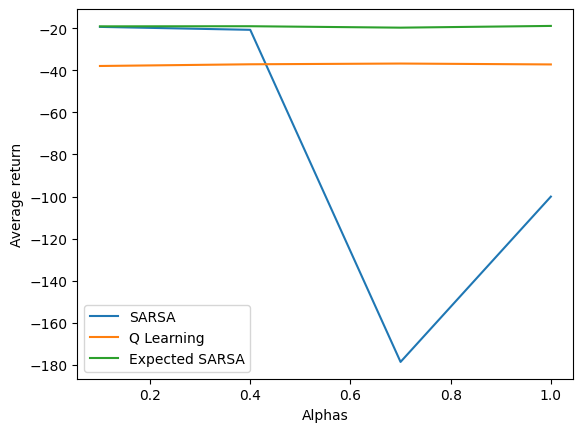

In [19]:
plt.plot(alphas, sarsa_returns, label="SARSA")
plt.plot(alphas, q_returns, label="Q Learning")
plt.plot(alphas, expected_sarsa_returns, label="Expected SARSA")

plt.xlabel("Alphas")
plt.ylabel("Average return")
plt.legend()
plt.show()

plt.show()

What do you observe?

1. Expected SARSA (Green Line) - The Best Performer

    Observation: It consistently achieves the highest average return (approximately -20) and remains stable across all learning rates (α).

    Why: Expected SARSA computes the target using the expected value of the next state (averaging over action probabilities). This eliminates the variance that comes from random action selection in standard SARSA, making it much more robust, even at high learning rates.

2. SARSA (Blue Line) - Sensitive to Learning Rate

    Observation: At lower learning rates (α<0.5), SARSA performs very well (around -20), matching Expected SARSA. However, as the learning rate increases toward 1.0, its performance plummets to -100.

    Why: SARSA is an on-policy algorithm. At low learning rates, it learns a "safe path" (away from the cliff edge) to avoid the risk of random exploration steps sending it over the edge. However, at high learning rates, the high variance in its updates (due to relying on a single sampled next action A′) causes instability, preventing it from effectively maintaining that safe policy.

3. Q-Learning (Orange Line) - Risky & Suboptimal (during training)

    Observation: Q-learning performance is stable but significantly lower than the others, hovering around -40.

    Why: Q-learning is an off-policy algorithm that learns the optimal (shortest) path, which hugs the edge of the cliff.

    Because the agent is still acting with an ϵ-greedy policy (10% random actions), walking right on the edge is dangerous. It frequently falls off the cliff due to those random exploration steps. Even though it learns the "optimal" path, its online performance suffers because it doesn't account for the risk inherent in its own exploration behavior.

Summary

The plot effectively demonstrates that Expected SARSA is superior in this setting because it learns the safer path (like SARSA) but with the stability of an expected-value update (like Q-learning), making it robust to changes in the learning rate.